## 以PCA將聲學特徵降維並且預測說話者的性別

### 資料來源 : 科技大擂台,與AI對話資料
### 1.前置作業：將音檔做性別標記
### 2.將音檔讀入並以spectrogram作為feature extraction的方式
### 3.將音檔特徵做pca降到2維做視覺化及做分類

In [1]:
import pandas as pd
import numpy as np
import librosa
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sns
from sklearn.linear_model.logistic import _logistic_loss

In [2]:
filenames = os.listdir("A")
filenames.sort()
categories = []
for filename in filenames:
    category = filename.split('.')[0] #1.xxxxxx.wav
    if category == '1': #1為男生,0為女生
        categories.append('1')
    else:
        categories.append('0')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head(5)

,filename,category
0,0.A0000005.wav,0
1,0.A0000006.wav,0
2,0.A0000007.wav,0
3,0.A0000008.wav,0
4,0.A0000009.wav,0


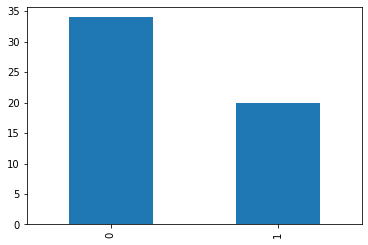

In [4]:
df['category'].value_counts().plot.bar()

In [11]:
#取得spectrogram特徵
def spectrogram(name):
    y, sr = librosa.load(r'A/{}'.format(name))
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=101)
    x = np.mean(spectrogram.T,axis=0)
    x = np.append(x,int(index.category))
    x = np.around(x, decimals=1)
    return x

In [10]:
spec = df['filename'][0]
spec = spectrogram(spec)
spec = spec.reshape(-1,102)

In [12]:
for row,index in df.iterrows():
    x = spectrogram(index.filename)
    spec = np.append(spec,[x],axis=0)
spec = np.delete(spec, 0, 0)
spec_df  = pd.DataFrame(spec)
spec_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,2.0,1.9,0.6,2.1,55.7,110.7,54.2,24.6,22.7,17.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.9,0.6,2.1,55.7,110.7,54.2,24.6,22.7,17.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.6,0.7,0.4,1.9,36.6,75.9,44.1,20.8,19.0,15.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6,0.7,0.4,1.9,36.6,75.9,44.1,20.8,19.0,15.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.1,0.3,0.1,0.4,18.7,39.9,36.6,22.2,14.6,6.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#how many components we want to keep
pca = PCA(n_components=2)

#將資料轉成兩個主成份
pca.fit(spec_df.iloc[:,0:101].values)
x_pca = pca.transform(spec_df.iloc[:,0:101].values)
x_pca = np.around(x_pca, decimals=0)

#原本有101種維度
print(spec_df.iloc[:,0:101].shape)

#轉型後變成只有兩種維度
print(x_pca.shape)

(54, 101)
(54, 2)


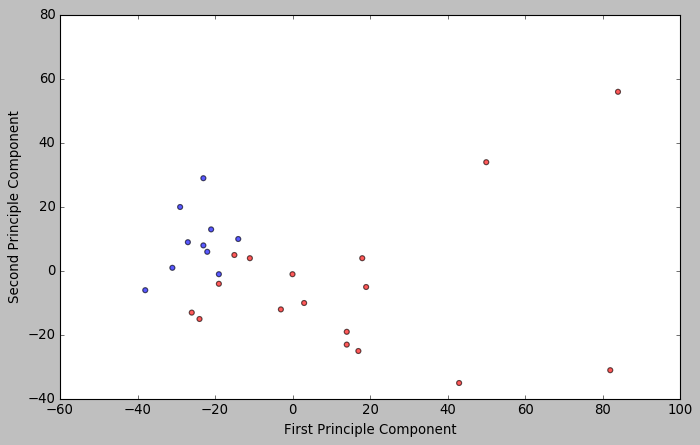

In [29]:
#畫出兩類別散佈圖
colors=['red','blue']
plt.style.use('classic')
plt.figure(figsize=(10,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=spec_df.iloc[:,101],alpha=0.4,cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.show()

In [30]:
#自定義costfunction
def loss(lr,x_pca):
    zero = np.round(lr.predict_proba(x_pca),3)[:34]
    one = np.round(lr.predict_proba(x_pca),3)[34:]
    zero = [i[0] for i in zero]
    one = [i[1] for i in one]
    loss = np.prod(zero)*np.prod(one)
    return loss

In [31]:
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

#訓練logistic模型
y = spec_df.iloc[:,101].values
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(x_pca, y)

print('%f' % loss(lr,x_pca))
print(lr.score(x_pca, y))
print(lr.coef_)
print(lr.intercept_)

0.013760
0.9259259259259259
[[-0.60278404  0.49081006]]
[-11.43453421]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers =('s', 'x', 'o', '^', 'v')
    colors = ('red', "blue",' lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors [ : len (np.unique(y))])

    # plot the decision surface
    x1_min, x1_max= X[:, 0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array( [xx1.ravel(), xx2. ravel()]).T)
    Z = Z. reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                        y=X[y == cl, 1],
                        alpha=0.8,
                        c=colors [idx],
                        marker=markers [idx],
                        label=cl,
                        edgecolor='black')
    
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test [:, 0],
                        X_test [:, 1],
                        C=' ',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        S=100,
                        label='test set ')

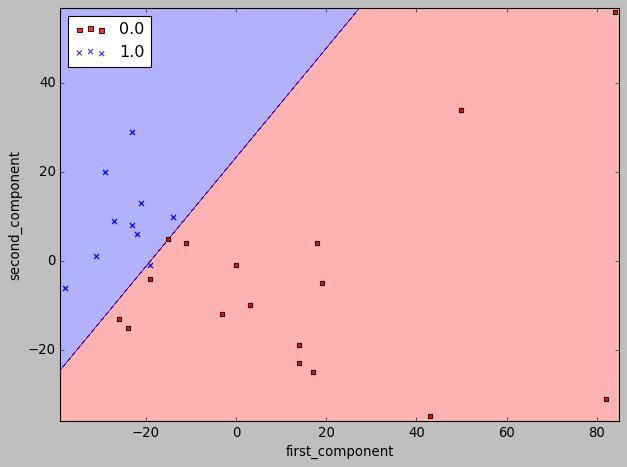

In [33]:
#畫出決策邊界
plot_decision_regions(x_pca,y,classifier=lr)
plt.xlabel('first_component')
plt.ylabel('second_component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

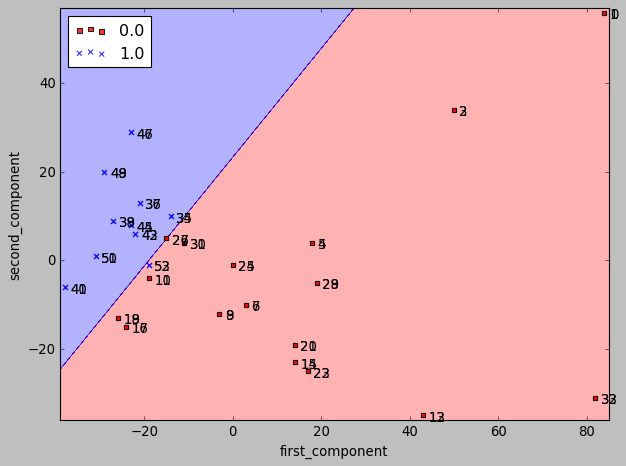

In [34]:
plot_decision_regions(x_pca,y,classifier=lr)
plt.xlabel('first_component')
plt.ylabel('second_component')
plt.legend(loc='upper left')
one = [int(i[0]) for i in x_pca]
two = [int(i[1]) for i in x_pca]
k = [str(x) for x in range(54)]

for k, X, Y in zip(k, one, two):
    plt.annotate(k,
    xy = (X, Y),
    xytext = (5,-5),
    textcoords = 'offset points')
plt.tight_layout()
plt.show()

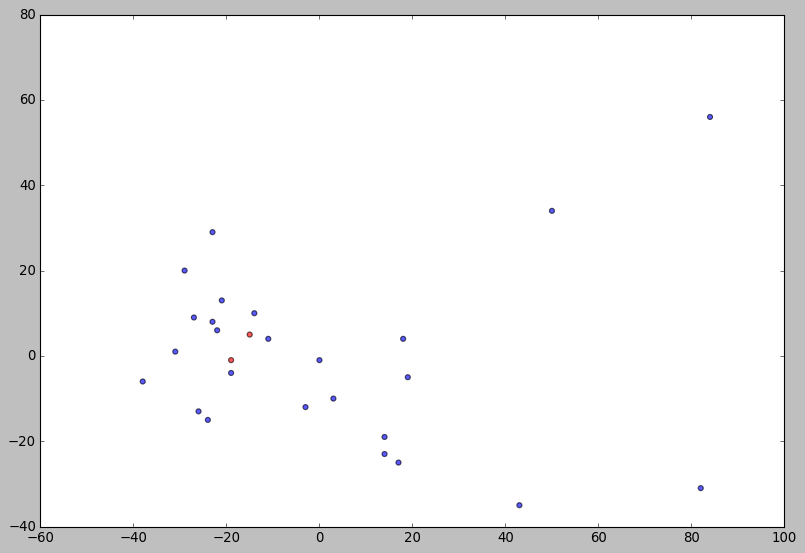

In [19]:
final_scores=lr.predict(x_pca)
plt.figure(figsize=(12,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c=(final_scores==y),alpha=0.4,cmap=matplotlib.colors.ListedColormap(colors))

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


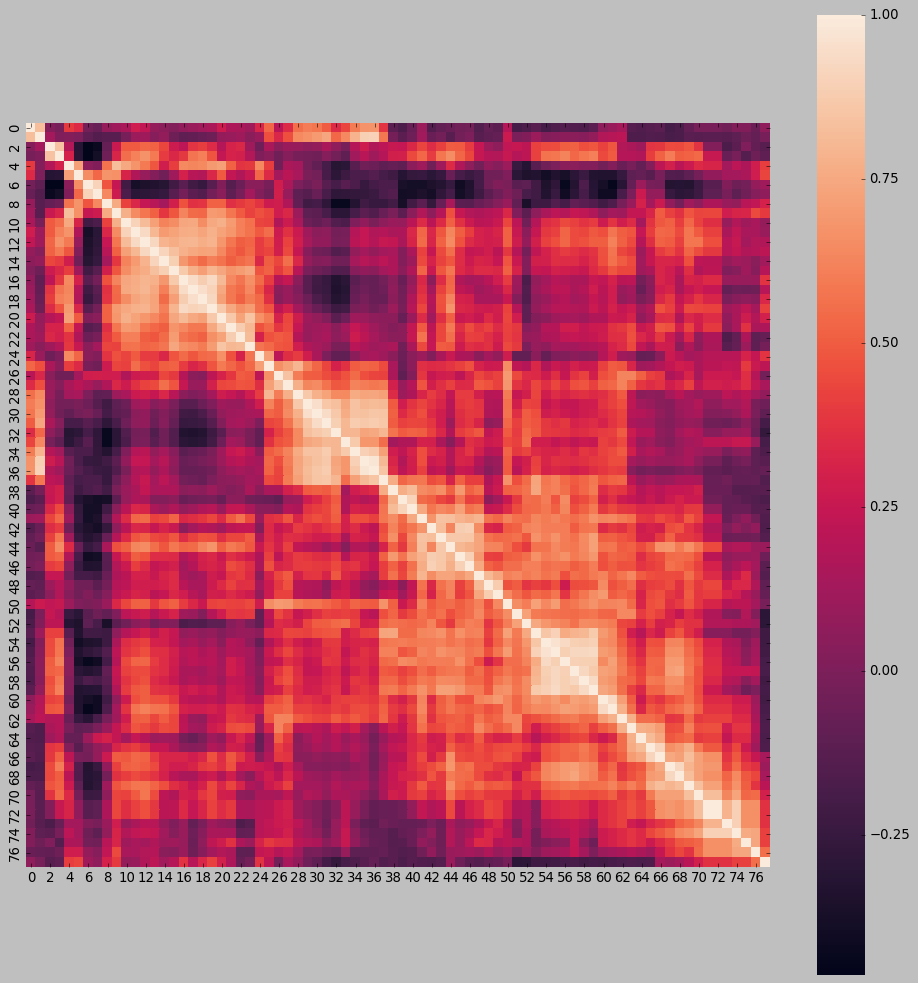

In [20]:
corr = spec_df.iloc[:,0:78].corr()
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(15,15))
sns.heatmap(corr, square=True, annot=False)
plt.show()

In [21]:
#how many components we want to keep
pca = PCA(n_components=1)

#前39維轉為一維
pca.fit(spec_df.iloc[:,0:39].values)
x_pca = pca.transform(spec_df.iloc[:,0:39].values)
x_pca1 = np.around(x_pca, decimals=0)

#reset PCA
pca = PCA(n_components=1)

#後39維
pca.fit(spec_df.iloc[:,39:78].values)
x_pca = pca.transform(spec_df.iloc[:,39:78].values)
x_pca2 = np.around(x_pca, decimals=0)

x_pca = np.hstack((x_pca1,x_pca2))

In [23]:
#再次訓練模型
y = spec_df.iloc[:,101].values
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(x_pca, y)

print('%f' % loss(lr,x_pca))
print(lr.score(x_pca, y))
print(lr.coef_)
print(lr.intercept_)

0.000009
0.8888888888888888
[[-0.17579603  4.89919423]]
[-3.19863552]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


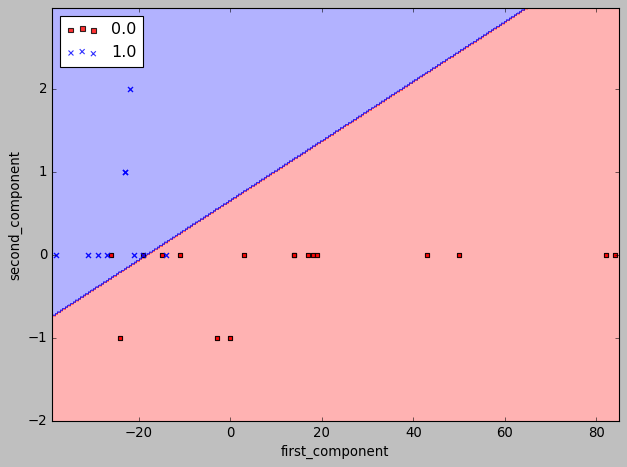

In [24]:
plot_decision_regions(x_pca,y,classifier=lr)
plt.xlabel('first_component')
plt.ylabel('second_component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()